In [3]:
nba <- read.csv("nba_2013.csv")

In [4]:
dim(nba)

[1] 481  31

In [5]:
head(nba,2)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,ellip.h,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
1,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,<8b>,144,216,28,23,26,30,122,171,2013-2014,2013
2,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,<8b>,190,332,43,40,57,71,203,265,2013-2014,2013


In [36]:
sapply(nba, sd, na.rm=TRUE)

player          pos          age bref_team_id            g           gs 
138.99700237   2.06200237   4.19826549   9.29802250  25.32271116  29.65846477 
          mp           fg          fga          fg.          x3p         x3pa 
897.25883955 171.83279327 368.85083258   0.09867234  50.85563872 132.75173216 
        x3p.          x2p         x2pa         x2p.         efg.           ft 
  0.15763286 147.22316113 294.17455411   0.10444756   0.09955205 103.66772464 
         fta          ft.          orb          drb          trb          ast 
131.24063851   0.16016617  62.10119067 145.34811589 200.35650719 131.01955653 
         stl          blk          tov           pf          pts       season 
 34.78359019  30.87538132  62.70169030  71.21362739 470.42222835   0.00000000 
  season_end 
  0.00000000

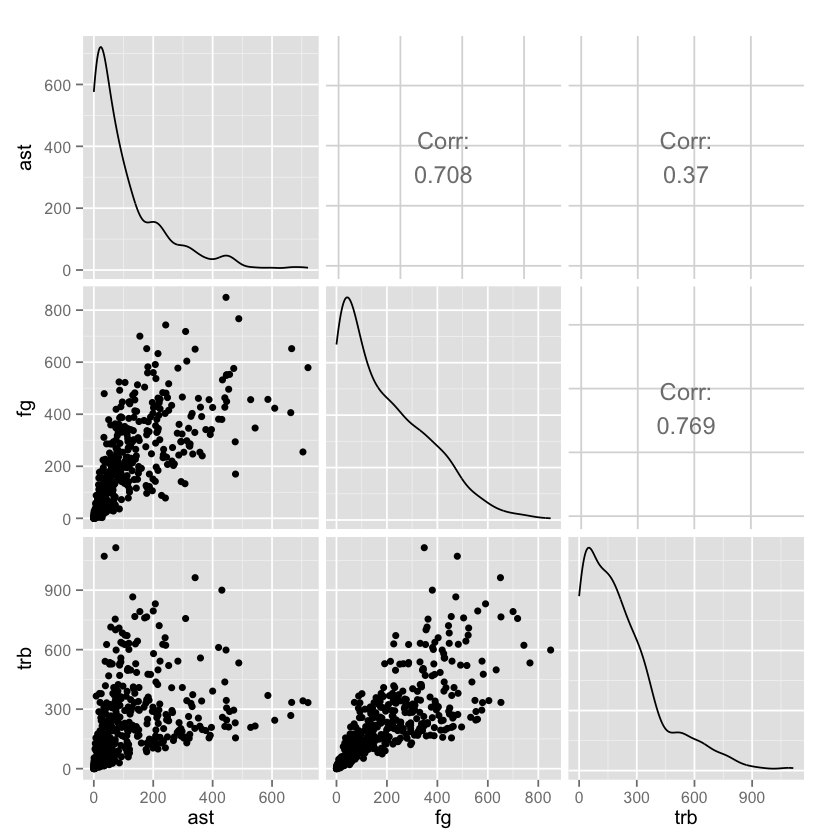

In [8]:
library(GGally)
ggpairs(nba[,c("ast", "fg", "trb")])

In [9]:
library(cluster)
set.seed(1)
isGoodCol <- function(col){
   sum(is.na(col)) == 0 && is.numeric(col) 
}
goodCols <- sapply(nba, isGoodCol)
clusters <- kmeans(nba[,goodCols], centers=5)
labels <- clusters$cluster

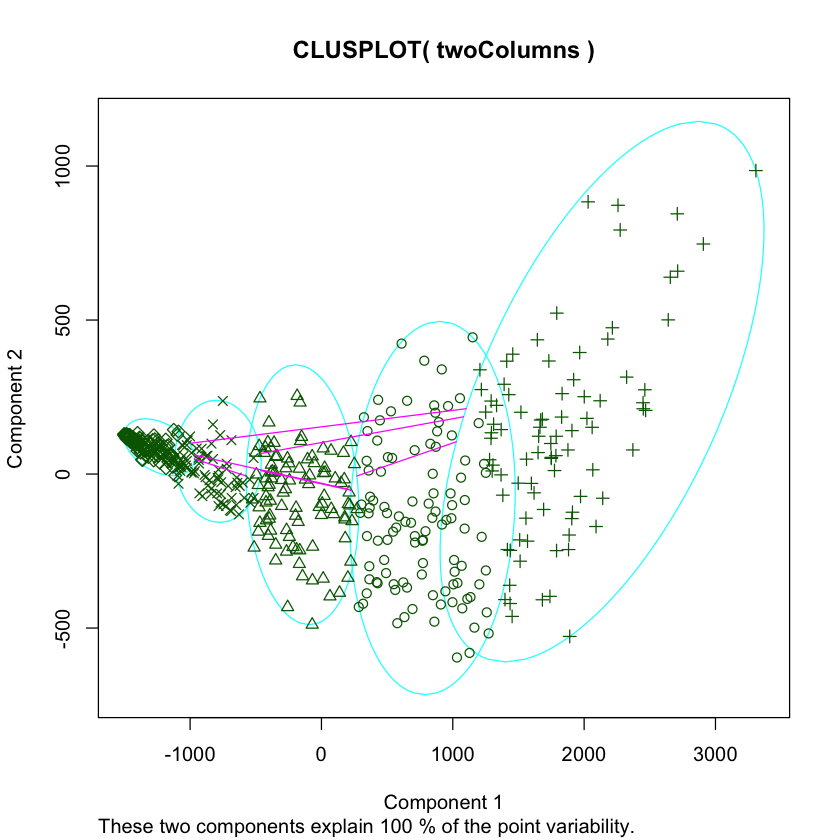

In [10]:
nba2d <- prcomp(nba[,goodCols], center=TRUE)
twoColumns <- nba2d$x[,1:2]
clusplot(twoColumns, labels)

In [11]:
trainRowCount <- floor(0.8 * nrow(nba))
set.seed(1)
trainIndex <- sample(1:nrow(nba), trainRowCount)
train <- nba[trainIndex,]
test <- nba[-trainIndex,]

In [12]:
fit <- lm(ast ~ fg, data=train)
predictions <- predict(fit, test)

In [13]:
summary(fit)


Call:
lm(formula = ast ~ fg, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-228.26  -35.38  -11.45   11.99  559.61 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.0585     7.1026   1.275    0.203    
fg            0.5307     0.0274  19.368   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 92.89 on 382 degrees of freedom
Multiple R-squared:  0.4954,	Adjusted R-squared:  0.4941 
F-statistic: 375.1 on 1 and 382 DF,  p-value: < 2.2e-16


In [14]:
library(randomForest)
predictorColumns <- c("age", "mp", "fg", "trb", "stl", "blk")
rf <- randomForest(train[predictorColumns], train$ast, ntree=100)
predictions <- predict(rf, test[predictorColumns])

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [20]:
mean((test["ast"] - predictions)^2)

[1] 5037.76

In [21]:
library(RCurl)
url <- "http://www.basketball-reference.com/boxscores/201506140GSW.html"
data <- readLines(url)

Loading required package: bitops


In [23]:
library(rvest)
page <- read_html(url)
table <- html_nodes(page, ".stats_table")[3]
rows <- html_nodes(table, "tr")
cells <- html_nodes(rows, "td a")
teams <- html_text(cells)

extractRow <- function(rows, i){
    if(i == 1){
        return
    }
    row <- rows[i]
    tag <- "td"
    if(i == 2){
        tag <- "th"
    }
    items <- html_nodes(row, tag)
    html_text(items)
}

scrapeData <- function(team){
    teamData <- html_nodes(page, paste("#",team,"_basic", sep=""))
    rows <- html_nodes(teamData, "tr")
    lapply(seq_along(rows), extractRow, rows=rows) 
}

data <- lapply(teams, scrapeData)

Loading required package: xml2


In [31]:
data

[[1]]
[[1]][[1]]
character(0)

[[1]][[2]]
 [1] "Starters" "MP"       "FG"       "FGA"      "FG%"      "3P"      
 [7] "3PA"      "3P%"      "FT"       "FTA"      "FT%"      "ORB"     
[13] "DRB"      "TRB"      "AST"      "STL"      "BLK"      "TOV"     
[19] "PF"       "PTS"      "+/-"     

[[1]][[3]]
 [1] "LeBron James" "44:46"        "15"           "34"           ".441"        
 [6] "3"            "8"            ".375"         "7"            "9"           
[11] ".778"         "1"            "13"           "14"           "11"          
[16] "1"            "0"            "2"            "5"            "40"          
[21] "-11"         

[[1]][[4]]
 [1] "Matthew Dellavedova" "41:41"               "2"                  
 [4] "9"                   ".222"                "1"                  
 [7] "5"                   ".200"                "0"                  
[10] "0"                   ""                    "0"                  
[13] "0"                   "0"                   "2"                  
[16] "3"                   "0"                   "2"                  
[19] "4"                   "5"                   "-19"                

[[1]][[5]]
 [1] "Tristan Thompson" "39:49"            "6"                "11"              
 [5] ".545"             "0"                "0"                ""                
 [9] "7"                "10"               ".700"             "5"               
[13] "5"                "10"               "0"                "2"               
[17] "2"                "1"                "4"                "19"              
[21] "-22"             

[[1]][[6]]
 [1] "Iman Shumpert" "37:18"         "3"             "9"            
 [5] ".333"          "3"             "6"             ".500"         
 [9] "1"             "2"             ".500"          "3"            
[13] "2"             "5"             "2"             "1"            
[17] "0"             "1"             "4"             "10"           
[21] "-10"          

[[1]][[7]]
 [1] "Timofey Mozgov" "9:19"           "0"              "1"             
 [5] ".000"           "0"              "0"              ""              
 [9] "0"              "0"              ""               "0"             
[13] "0"              "0"              "0"              "1"             
[17] "0"              "2"              "2"              "0"             
[21] "-4"            

[[1]][[8]]
character(0)

[[1]][[9]]
 [1] "J.R. Smith" "35:42"      "5"          "15"         ".333"      
 [6] "4"          "14"         ".286"       "0"          "0"         
[11] ""           "1"          "6"          "7"          "2"         
[16] "1"          "2"          "1"          "3"          "14"        
[21] "-6"        

[[1]][[10]]
 [1] "James Jones" "17:47"       "0"           "1"           ".000"       
 [6] "0"           "1"           ".000"        "0"           "0"          
[11] ""            "0"           "1"           "1"           "0"          
[16] "1"           "0"           "0"           "4"           "0"          
[21] "+1"         

[[1]][[11]]
 [1] "Mike Miller" "13:38"       "1"           "1"           "1.000"      
 [6] "1"           "1"           "1.000"       "0"           "0"          
[11] ""            "0"           "0"           "0"           "0"          
[16] "0"           "0"           "1"           "2"           "3"          
[21] "+6"         

[[1]][[12]]
[1] "Joe Harris"   "Did Not Play"

[[1]][[13]]
[1] "Kyrie Irving" "Did Not Play"

[[1]][[14]]
[1] "Brendan Haywood" "Did Not Play"   

[[1]][[15]]
[1] "Shawn Marion" "Did Not Play"

[[1]][[16]]
[1] "Kendrick Perkins" "Did Not Play"    

[[1]][[17]]
 [1] "Team Totals" "240"         "32"          "81"          ".395"       
 [6] "12"          "35"          ".343"        "15"          "21"         
[11] ".714"        "10"          "27"          "37"          "17"         
[16] "10"          "4"           "10"          "28"          "91"         
[21] ""           


[[2]]
[[2]][[1]]
character(0)

[[2]][[2]]
 [1]